In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import OneLakeDatastore, OneLakeArtifact
from decouple import config

subscription_id = config("SUBS_ID") 
resource_group = config("RESOURCE")
workspace = config("WORKSPACE")

ml_client = MLClient(DefaultAzureCredential(),
                     subscription_id,
                     resource_group,
                     workspace)

artifact = OneLakeArtifact(name=config("WORKSPACE_FABS_ID"),
                           type="lake_house")
store = OneLakeDatastore(
    name="onelake_lh_for_azureml",
    description="Credential-less OneLake datastore.",
    endpoint="msit-onelake.dfs.fabric.microsoft.com",
    artifact=artifact,
    one_lake_workspace_name="Playground")


In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import random
import seaborn as sns
import traceback
import uuid
from datetime import datetime, timedelta
from decouple import config
from faker import Faker
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Promotion = ongoing
# Resignation = ongoing
# Turnover = done

fake = Faker()

class HRAnalyticsModel:
    def __init__(self):
        self.conn = psycopg2.connect(host=config("PSQL_HOST2"),
                                     database=config("PSQL_DB2"),
                                     user=config("PSQL_USER2"),
                                     password=config("PSQL_PASS2"),
                                     port=config("PSQL_PORT2"))

        self.employees_df = self.load_attendance()
        self.employees_df = self.load_departments()
        self.employees_df = self.load_employees()
        self.employees_df = self.load_performance()
        self.employees_df = self.load_training()


    def load_attendance(self):
        query = """
            SELECT attendance_id, employee_id, date, status, hours_worked
            FROM s_attendance;
        """
        
        return pd.read_sql(query, self.conn)
    
    
    def load_departments(self):
        query = """
            SELECT department_id, department_name, location, budget
            FROM s_departments;
        """
        
        return pd.read_sql(query, self.conn)
    
    
    def load_employees(self):
        query = """
            SELECT employee_id, first_name, last_name, department_id, job_title, hire_date, manager_id, status
            FROM s_employees;
        """
        
        return pd.read_sql(query, self.conn)
    
    
    def load_performance(self):
        query = """
            SELECT performance_id, employee_id, review_date, rating, reviewer_id
            FROM s_performance;
        """
        
        return pd.read_sql(query, self.conn)
    
    
    def load_training(self):
        query = """
            SELECT training_id, employee_id, training_name, category, score, completion_date
            FROM s_training;
        """
        
        return pd.read_sql(query, self.conn)

    
    """Analytics"""
    def calculate_turnover_rate(self):
        total_employees = len(self.employees_df)
        departed = len(self.employees_df[self.employees_df['status'] != 'active'])
        turnover_rate = (departed / total_employees) * 100 if total_employees > 0 else 0
        
        return round(turnover_rate, 2)
    
    
    def analyze_department_performance(self):
        merged_df = pd.merge(self.performance_df, self.employees_df, on='employee_id')
        dept_performance = merged_df.groupby('department')['rating'].agg(['mean',
                                                                          'count',
                                                                          'std',
                                                                          'min',
                                                                          'max']).round(2)
        
        return dept_performance
    
    
    def attendance_analysis(self):
        analysis = {
            'total_days_recorded': len(self.attendance_df),
            'present_days': len(self.attendance_df[self.attendance_df['status'] == 'present']),
            'absent_days': len(self.attendance_df[self.attendance_df['status'] == 'absent']),
            'late_days': len(self.attendance_df[self.attendance_df['status'] == 'late']),
            'average_hours_worked': round(self.attendance_df['hours_worked'].mean(), 2),
            'attendance_rate': round((len(self.attendance_df[self.attendance_df['status'] == 'present']) /
                                      len(self.attendance_df)) * 100, 2)
        }
        
        return analysis
    
    
    def salary_analysis(self):
        salary_stats = self.employees_df.groupby('department')['salary'].agg(['mean',
                                                                              'median',
                                                                              'std',
                                                                              'min',
                                                                              'max',
                                                                              'count']).round(2)
        
        # Convert to millions for readability
        for col in ['mean', 'median', 'std', 'min', 'max']:
            salary_stats[col] = (salary_stats[col] / 1000000).round(2)
        
        salary_stats.rename(columns={
            'mean': 'avg_salary_million',
            'median': 'median_salary_million',
            'std': 'std_salary_million',
            'min': 'min_salary_million', 
            'max': 'max_salary_million'
        }, inplace=True)
        
        return salary_stats
    
    
    def retention_analysis(self):
        current_date = datetime.now()
        self.employees_df['tenure_years'] = ((current_date - pd.to_datetime(self.employees_df['hire_date'])).dt.days /
                                             365.25).round(2)
        retention_stats = self.employees_df.groupby('department')['tenure_years'].agg(['mean',
                                                                                       'median',
                                                                                       'std',
                                                                                       'count']).round(2)
        
        return retention_stats
    
    
    def training_effectiveness(self):
        latest_performance = self.performance_df.sort_values('review_date').groupby('employee_id').last().reset_index()
        merged_data = pd.merge(self.training_df, latest_performance, on='employee_id')
        
        effectiveness = merged_data.groupby('training_name').agg({
            'score': 'mean',
            'rating': 'mean',
            'employee_id': 'count'
        }).round(2).rename(columns={'employee_id': 'participants_count'})
        
        return effectiveness
    
    
    def generate_comprehensive_report(self):
        comprehensive_report = {
            'turnover_rate': self.calculate_turnover_rate(),
            'department_performance': self.analyze_department_performance(),
            'attendance_stats': self.attendance_analysis(),
            'salary_analysis': self.salary_analysis(),
            'retention_analysis': self.retention_analysis(),
            'training_effectiveness': self.training_effectiveness(),
            'employee_summary': {
                'total_employees': len(self.employees_df),
                'active_employees': len(self.employees_df[self.employees_df['status'] == 'active']),
                'departments_count': self.employees_df['department'].nunique(),
                'average_salary': f"Rp {self.employees_df['salary'].mean():,.0f}",
                'average_tenure': f"{self.employees_df['tenure_years'].mean():.1f} years"
            }
        }
        
        return comprehensive_report
    
    
    """Visualization"""
    def plot_turnover_by_department(self):
        turnover_by_dept = self.employees_df.groupby('department')['status'].apply(lambda x: (x != 'active').mean() * 100).round(2)
        
        plt.figure(figsize=(10, 6))
        turnover_by_dept.sort_values().plot(kind='bar', color='skyblue')
        plt.title('Turnover Rate by Department')
        plt.xlabel('Department')
        plt.ylabel('Turnover Rate (%)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_salary_distribution(self):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        self.employees_df['salary_million'] = self.employees_df['salary'] / 1000000
        sns.histplot(self.employees_df['salary_million'], bins=20, kde=True)
        plt.title('Salary Distribution (in millions)')
        plt.xlabel('Salary (Million IDR)')
        
        plt.subplot(1, 2, 2)
        salary_by_dept = self.employees_df.groupby('department')['salary_million'].mean().sort_values()
        salary_by_dept.plot(kind='bar', color='lightgreen')
        plt.title('Average Salary by Department')
        plt.xlabel('Department')
        plt.ylabel('Average Salary (Million IDR)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def plot_performance_trends(self):
        merged_df = pd.merge(self.performance_df, self.employees_df, on='employee_id')
        performance_trend = merged_df.groupby([pd.to_datetime(merged_df['review_date']).dt.year, 
                                               'department'])['rating'].mean().unstack()
        
        plt.figure(figsize=(12, 6))
        performance_trend.plot(marker='o')
        plt.title('Performance Rating Trend by Department')
        plt.xlabel('Year')
        plt.ylabel('Average Rating')
        plt.legend(title='Department')
        plt.grid(True)
        plt.show()
    
    def plot_attendance_patterns(self):
        plt.figure(figsize=(15, 10))
        
        # Attendance by day of week
        self.attendance_df['day_of_week'] = pd.to_datetime(self.attendance_df['date']).dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        
        plt.subplot(2, 2, 1)
        attendance_by_day = self.attendance_df['day_of_week'].value_counts().reindex(day_order)
        attendance_by_day.plot(kind='bar', color='lightblue')
        plt.title('Attendance by Day of Week')
        plt.xlabel('Day')
        plt.ylabel('Count')
        
        # Attendance status distribution
        plt.subplot(2, 2, 2)
        status_counts = self.attendance_df['status'].value_counts()
        plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%')
        plt.title('Attendance Status Distribution')
        
        # Average hours by department
        plt.subplot(2, 2, 3)
        merged_attendance = pd.merge(self.attendance_df, self.employees_df, on='employee_id')
        hours_by_dept = merged_attendance.groupby('department')['hours_worked'].mean().sort_values()
        hours_by_dept.plot(kind='bar', color='orange')
        plt.title('Average Hours Worked by Department')
        plt.xlabel('Department')
        plt.ylabel('Average Hours')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

## 1. Inheritance Structure
#### Call constructor parent
#### Dictionary for saving ML model
```python
class HRPredictiveModel(HRAnalyticsModel):
    def __init__(self):
        super().__init__()
        self.ml_models = {}
```
##### Explanation: A class that inherits all functionality from HRAnalyticsModel and adds machine learning capabilities

## 2. Feature Engineering (prepare_features_for_ml)
```python
def prepare_features_for_ml(self):
    features_df = self.employees_df.copy()
```
#### A. Numerical Feature Engineering:
##### Years worked & Handle missing values
```python
features_df['tenure'] = (datetime.now() - pd.to_datetime(features_df['hire_date'])).dt.days / 365.25
features_df['tenure'] = features_df['tenure'].fillna(0)
```
##### Salary normalization gaji (0-1)
```python
features_df['salary_normalized'] = features_df['salary'] / features_df['salary'].max()
features_df['salary_normalized'] = features_df['salary_normalized'].fillna(0)
```
#### B. Performance Data Aggregation:
##### Aggregate data performance per employee
```python
perf_agg = self.performance_df.groupby('employee_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
perf_agg.columns = ['employee_id', 'performance_mean', 'performance_std', 'performance_count']
```
##### Merge with main data
```python
features_df = features_df.merge(perf_agg, on='employee_id', how='left')
```
##### Handle missing values
```python
features_df['performance_mean'] = features_df['performance_mean'].fillna(features_df['performance_mean'].median())
features_df['performance_std'] = features_df['performance_std'].fillna(0)
features_df['performance_count'] = features_df['performance_count'].fillna(0)
```
#### C. Attendance Data Aggregation:
##### Aggregate data attendance (Average working hours and attendance rate (0-1))
```python
attendance_agg = self.attendance_df.groupby('employee_id').agg({
    'hours_worked': 'mean',
    'status': lambda x: (x == 'absent').mean()
})
```
#### D. Categorical Data Encoding:
##### Convert department ke one-hot encoding
```python
if 'department' in features_df.columns:
    features_df = pd.get_dummies(features_df, columns=['department'], prefix='dept')
```
##### Convert job title ke one-hot encoding
```python
if 'job_title' in features_df.columns:
    features_df = pd.get_dummies(features_df, columns=['job_title'], prefix='job')
```
## 3. Dataset Preparation (create_turnover_prediction_dataset)
##### Get engineered features
```python
def create_turnover_prediction_dataset(self):
    features_df = self.prepare_features_for_ml()
```
#### A. Label Creation:
##### Create target variable (label) with 1 = resigned, 0 = active
```python
y = (features_df['status'] != 'active').astype(int)
print(f"Label value counts: {y.value_counts().to_dict()}")
```
#### B. Feature Selection:
##### Drop columns that are not needed for training

```python
columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]

X = features_df.drop(columns_to_drop, axis=1, errors='ignore')
```
##### Ensure will_resign doesn't exist (if it does)
```python
if 'will_resign' in X.columns:
    X = X.drop('will_resign', axis=1)
```
## 4. Model Training (train_turnover_prediction_model)
##### Get features and labels
```python
def train_turnover_prediction_model(self):
    X, y = self.create_turnover_prediction_dataset()
```
#### A. Data Preprocessing:
##### Save features name
##### Handle missing values with median imputation
```python
feature_names = X.columns.tolist()

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
```
#### B. Train-Test Split:
##### Split data 80-20 with stratification
##### stratify=y for Maintain class distribution
```python
X_train, X_test, y_train, y_test = train_test_split(X_imputed,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
```
#### C. Model Training:
##### Use the Random Forest classifier
##### Training
```python
model = RandomForestClassifier(n_estimators=100,
                               random_state=42,
                               class_weight='balanced')
model.fit(X_train, y_train)
```
#### D. Model Evaluation:
##### Predict dan evaluate
##### Detailing metrics
```python
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
```
#### E. Model Storage:
##### Save models dan preprocessing components
```python
model.feature_names_ = feature_names
self.ml_models['turnover_prediction'] = model
self.ml_models['imputer'] = imputer
self.ml_models['feature_names'] = feature_names
```
## 5. Prediction (predict_turnover_risk)
##### Auto-train if the model doesn't exist yet
```python
def predict_turnover_risk(self, employee_id=None):
    if 'turnover_prediction' not in self.ml_models:
        self.train_turnover_prediction_model()
```
#### A. Feature Preparation for Prediction:
##### Prepare features in the same way as training.
```python
features_df = self.prepare_features_for_ml()
columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]

X_all = features_df.drop(columns_to_drop, axis=1, errors='ignore')
```
#### B. Feature Alignment:
##### Ensure features match training
##### Handle missing features with loop and zero
##### Handle extra features and discard unnecessary ones
##### Sort features according to training
```python
feature_names = self.ml_models['feature_names']
missing_features = set(feature_names) - set(X_all.columns)

for feature in missing_features:
    X_all[feature] = 0

extra_features = set(X_all.columns) - set(feature_names)
X_all = X_all.drop(list(extra_features), axis=1)
X_all = X_all[feature_names]
```
#### C. Prediction:
##### Preprocessing dan prediction
##### Apply imputer
##### Probability class 1
##### Format results
```python
X_all_imputed = self.ml_models['imputer'].transform(X_all)
predictions = self.ml_models['turnover_prediction'].predict_proba(X_all_imputed)[:, 1]

results['turnover_risk'] = (predictions * 100).round(2)
```
## 6. Feature Importance Analysis
##### Get importance scores from the model & Importance scores from Random Forest
```python
def analyze_feature_importance(self):
    feature_importances = pd.DataFrame({
        'feature': model.feature_names_,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
```
## Engineered Key Features:
- tenure - Years of service
- salary_normalized - Normalized salary (0-1)
- performance_mean - Average performance rating
- performance_std - Performance consistency
- avg_hours_worked - Average working hours
- absence_rate - Absence rate (0-1)
- One-hot encoded departments - dept_IT, dept_HR, etc.
- One-hot encoded job titles - job_Manager, job_Analyst, etc.

## Algorithms Used:
- Random Forest - Robust ensemble method for classification
- Class Weight Balancing - Handle imbalance between active vs resigned
- Median Imputation - Handle missing values
- Stratified Sampling - Maintain class distribution in split

In [17]:
"""Sample ML turnover prediction"""
class HRPredictiveModel(HRAnalyticsModel):
    def __init__(self):
        super().__init__()
        self.ml_models = {}

    def prepare_features_for_ml(self):
        features_df = self.employees_df.copy()

        # Feature engineering - make sure handle missing values
        features_df['tenure'] = (datetime.now() - pd.to_datetime(features_df['hire_date'])).dt.days / 365.25
        features_df['tenure'] = features_df['tenure'].fillna(0)

        features_df['salary_normalized'] = features_df['salary'] / features_df['salary'].max()
        features_df['salary_normalized'] = features_df['salary_normalized'].fillna(0)

        # Aggregate performance data
        perf_agg = self.performance_df.groupby('employee_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
        perf_agg.columns = ['employee_id', 'performance_mean', 'performance_std', 'performance_count']

        features_df = features_df.merge(perf_agg, on='employee_id', how='left')

        # Fill missing performance values
        features_df['performance_mean'] = features_df['performance_mean'].fillna(features_df['performance_mean'].median())
        features_df['performance_std'] = features_df['performance_std'].fillna(0)
        features_df['performance_count'] = features_df['performance_count'].fillna(0)

        # Aggregate attendance data
        if not self.attendance_df.empty:
            attendance_agg = self.attendance_df.groupby('employee_id').agg({
                'hours_worked': 'mean',
                'status': lambda x: (x == 'absent').mean()  # absence rate
            }).reset_index()
            attendance_agg.columns = ['employee_id', 'avg_hours_worked', 'absence_rate']
            features_df = features_df.merge(attendance_agg, on='employee_id', how='left')

            # Fill missing attendance values
            features_df['avg_hours_worked'] = features_df['avg_hours_worked'].fillna(features_df['avg_hours_worked'].median())
            features_df['absence_rate'] = features_df['absence_rate'].fillna(0)

        else:
            features_df['avg_hours_worked'] = 8.0  # default value
            features_df['absence_rate'] = 0.0

        # Convert categorical variables - make sure existing columns
        if 'department' in features_df.columns:
            features_df = pd.get_dummies(features_df, columns=['department'], prefix='dept')

        if 'job_title' in features_df.columns:
            features_df = pd.get_dummies(features_df, columns=['job_title'], prefix='job')

        return features_df

    def create_turnover_prediction_dataset(self):
        features_df = self.prepare_features_for_ml()

        if 'status' not in features_df.columns:
            print("Error: 'status' column not found in features_df")
            return None, None

        y = (features_df['status'] != 'active').astype(int)
        print(f"Label value counts: {y.value_counts().to_dict()}")
        columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
        columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]
        x = features_df.drop(columns_to_drop, axis=1, errors='ignore')

        if 'will_resign' in x.columns:
            x = x.drop('will_resign', axis=1)

        print(f"X columns: {x.columns.tolist()}")
        print(f"X shape: {x.shape}, y shape: {y.shape}")

        return x, y

    def train_turnover_prediction_model(self):
        try:
            x, y = self.create_turnover_prediction_dataset()

            if x is None or y is None:
                print("Failed to create dataset")

                return None

            feature_names = x.columns.tolist()
            print(f"Feature names for model: {feature_names}")

            imputer = SimpleImputer(strategy='median')
            x_imputed = imputer.fit_transform(x)
            x_train, x_test, y_train, y_test = train_test_split(x_imputed,
                                                                y,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                stratify=y)

            model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            print("Model Evaluation:")
            print(classification_report(y_test, y_pred))

            model.feature_names_ = feature_names

            self.ml_models['turnover_prediction'] = model
            self.ml_models['imputer'] = imputer
            self.ml_models['feature_names'] = feature_names

            print(f"Model trained successfully with {len(feature_names)} features")

            return model

        except Exception as e:
            print(f"Error training model: {e}")
            traceback.print_exc()

            return None

    def predict_turnover_risk(self, employee_id=None):
        try:
            if 'turnover_prediction' not in self.ml_models:
                print("Training model first...")
                self.train_turnover_prediction_model()

                if 'turnover_prediction' not in self.ml_models:
                    return None

            features_df = self.prepare_features_for_ml()

            # Ensure to drop several duplicate columns when training
            columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
            columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]

            x_all = features_df.drop(columns_to_drop, axis=1, errors='ignore')

            if 'will_resign' in x_all.columns:
                x_all = x_all.drop('will_resign', axis=1)

            feature_names = self.ml_models['feature_names']
            print(f"Expected features: {feature_names}")
            print(f"Available features: {x_all.columns.tolist()}")

            missing_features = set(feature_names) - set(x_all.columns)
            extra_features = set(x_all.columns) - set(feature_names)

            if missing_features:
                print(f"Warning: Missing features {missing_features}, filling with 0")

                for feature in missing_features:
                    x_all[feature] = 0

            if extra_features:
                print(f"Warning: Dropping extra features {extra_features}")
                x_all = x_all.drop(list(extra_features), axis=1)

            x_all = x_all[feature_names]

            # Impute missing values
            x_all_imputed = self.ml_models['imputer'].transform(x_all)

            predictions = self.ml_models['turnover_prediction'].predict_proba(x_all_imputed)[:, 1]
            results = features_df[['employee_id', 'first_name', 'last_name']].copy()

            # Add department if needed
            if 'department' in features_df.columns:
                results['department'] = features_df['department']

            elif 'dept_IT' in features_df.columns:
                dept_columns = [col for col in features_df.columns if col.startswith('dept_')]

                if dept_columns:
                    results['department'] = features_df[dept_columns].idxmax(axis=1).str.replace('dept_', '')

            results['turnover_risk'] = (predictions * 100).round(2)
            results['status'] = features_df['status']

            return results.sort_values('turnover_risk', ascending=False)

        except Exception as e:
            print(f"Error predicting turnover risk: {e}")
            traceback.print_exc()

            return None

    def analyze_feature_importance(self):
        try:
            if 'turnover_prediction' not in self.ml_models:
                self.train_turnover_prediction_model()

            model = self.ml_models['turnover_prediction']
            x, _ = self.create_turnover_prediction_dataset()

            feature_importances = pd.DataFrame({
                'feature': model.feature_names_,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(12, 8))
            sns.barplot(data=feature_importances.head(10), x='importance', y='feature')
            plt.title('Top 10 Features Affecting Employee Turnover')
            plt.tight_layout()
            plt.show()

            return feature_importances

        except Exception as e:
            print(f"Error analyzing feature importance: {e}")

            return None

In [18]:
# Testing
try:
    hr_ml_model = HRPredictiveModel()
    
    print("=== TRAINING ===")
    ml_model = hr_ml_model.train_turnover_prediction_model()
    
    if ml_model is not None:
        print("=== FEATURE VALIDATION ===")
        print("Model feature names:", ml_model.feature_names_)
        
        # Prepare features untuk prediction
        features_df = hr_ml_model.prepare_features_for_ml()
        columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
        columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]
        X_pred = features_df.drop(columns_to_drop, axis=1, errors='ignore')
        
        print("Prediction features:", X_pred.columns.tolist())
        print("Feature match:", set(ml_model.feature_names_) == set(X_pred.columns))
        
        print("=== PREDICTION ===")
        risk_scores = hr_ml_model.predict_turnover_risk()
        if risk_scores is not None:
            print("\nTop 10 employees with highest turnover risk:")
            print(risk_scores.head(10))
            
            # Analisis hasil
            print(f"\nRisk score statistics:")
            print(f"Min: {risk_scores['turnover_risk'].min():.2f}%")
            print(f"Max: {risk_scores['turnover_risk'].max():.2f}%")
            print(f"Avg: {risk_scores['turnover_risk'].mean():.2f}%")
            print(f"Active employees avg risk: {risk_scores[risk_scores['status'] == 'active']['turnover_risk'].mean():.2f}%")
            print(f"Resigned employees avg risk: {risk_scores[risk_scores['status'] == 'resigned']['turnover_risk'].mean():.2f}%")
                
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

=== TRAINING ===
Label value counts: {0: 83, 1: 17}
X columns: ['salary', 'manager_id', 'tenure', 'salary_normalized', 'performance_mean', 'performance_std', 'performance_count', 'avg_hours_worked', 'absence_rate', 'dept_Finance', 'dept_HR', 'dept_IT', 'dept_Marketing', 'dept_Operations', 'dept_Sales', 'job_Account Manager', 'job_Accountant', 'job_Auditor', 'job_Business Development', 'job_Content Creator', 'job_Data Analyst', 'job_Finance Manager', 'job_Financial Analyst', 'job_HR Manager', 'job_HR Specialist', 'job_IT Manager', 'job_Logistics Coordinator', 'job_Marketing Manager', 'job_Marketing Specialist', 'job_Operations Manager', 'job_Recruiter', 'job_SEO Analyst', 'job_Sales Manager', 'job_Sales Representative', 'job_Software Engineer', 'job_Supply Chain Specialist', 'job_System Admin', 'job_Training Coordinator']
X shape: (100, 38), y shape: (100,)
Feature names for model: ['salary', 'manager_id', 'tenure', 'salary_normalized', 'performance_mean', 'performance_std', 'performanc

=== HR ANALYTICS REPORT ===
Total Employees: 100
Active Employees: 86
Turnover Rate: 14.0%

Average Salary: Rp 74,916,247
Average Tenure: 6.2 years

=== DEPARTMENT PERFORMANCE ===
            mean  count   std  min  max
department                             
Finance     4.00     45  0.56  3.1  5.0
HR          3.89     30  0.53  3.1  4.9
IT          4.06     60  0.61  3.1  5.0
Marketing   4.02     57  0.56  3.0  5.0
Operations  3.90     69  0.56  3.0  5.0
Sales       3.88     39  0.61  3.0  5.0

=== ATTENDANCE STATS ===
total_days_recorded: 5504
present_days: 4686
absent_days: 294
late_days: 356
average_hours_worked: 7.86
attendance_rate: 85.14


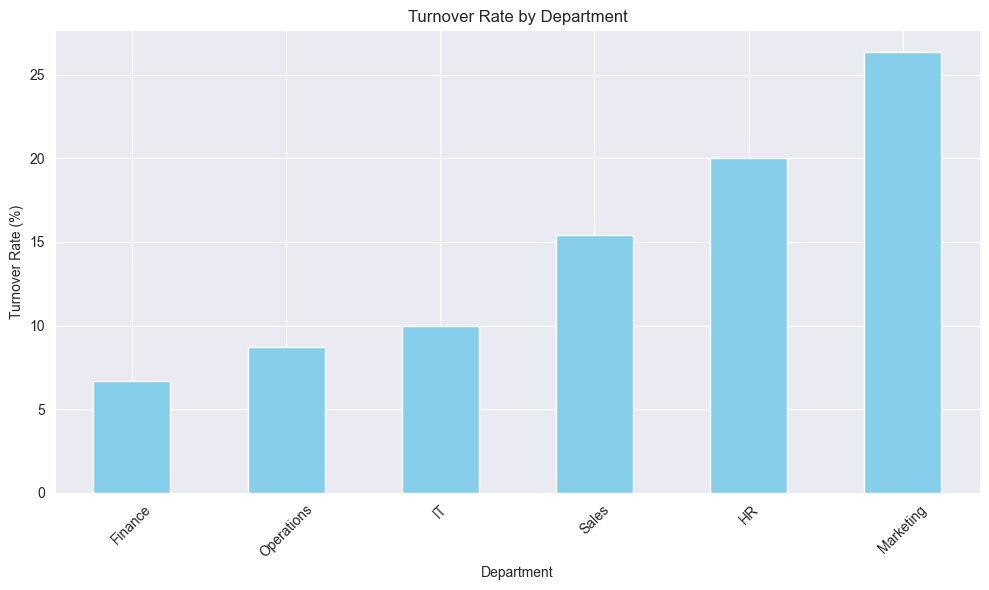

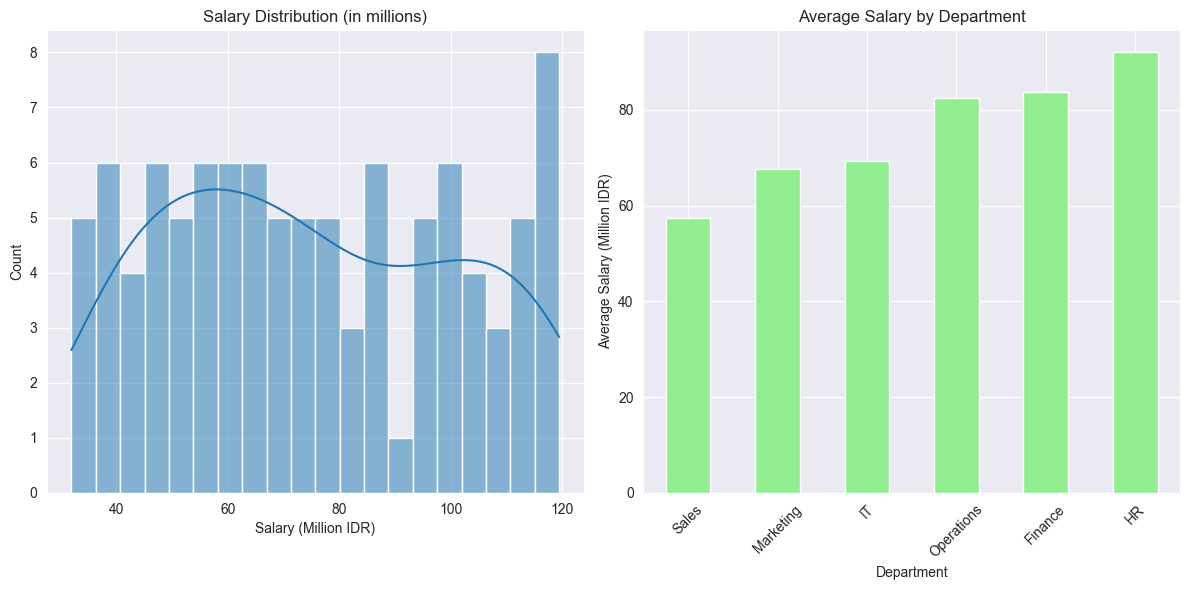

<Figure size 1200x600 with 0 Axes>

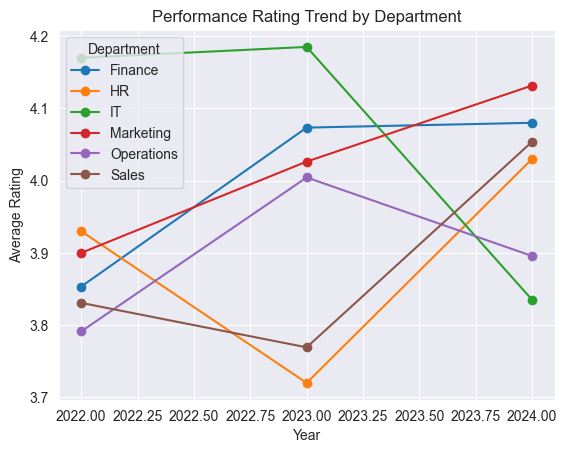

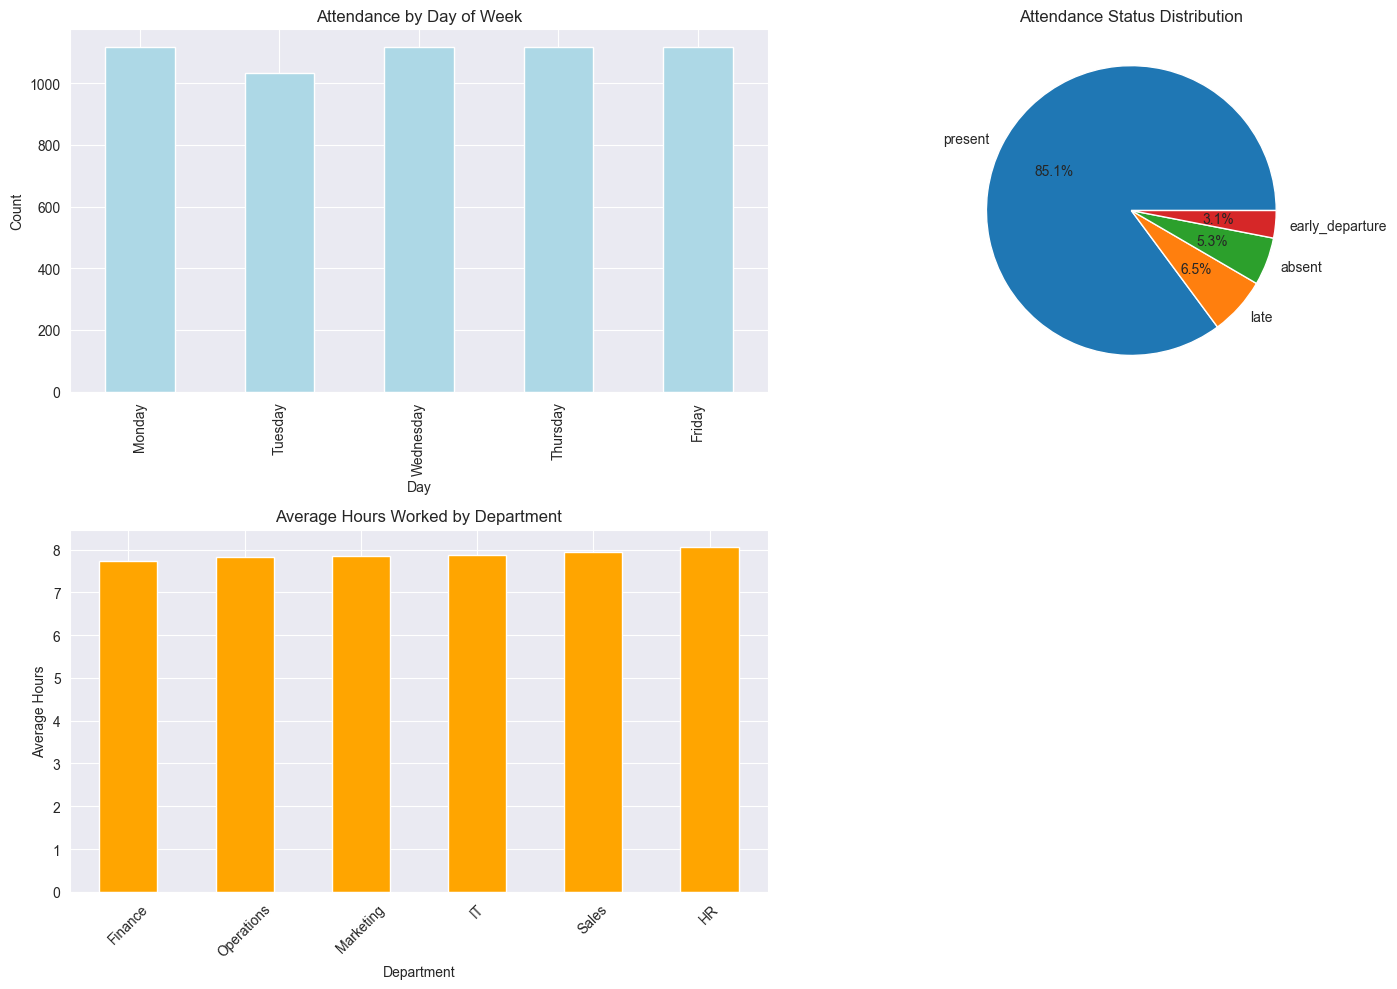


Sample of employees data:
                            employee_id first_name last_name  \
0  a779a351-e568-40de-b4da-4706db16afaa    Brandon   Johnson   
1  2cf78e8c-44dd-45e1-ac2f-908f678f881a     Daniel    Arnold   
2  0dd45c0d-7ec5-48e5-8a53-763185dff310      David    Barnes   
3  ad8ef208-9eb8-4844-b644-2ebd11439177     Hannah      Bell   
4  39f851f6-f086-4593-a99f-481434272306    Antonio    Turner   

                            email  department                job_title  \
0     monicaclark@pertamina.co.id       Sales     Sales Representative   
1  halljacqueline@pertamina.co.id          HR     Training Coordinator   
2        leewhite@pertamina.co.id  Operations  Supply Chain Specialist   
3     blairalyssa@pertamina.co.id          IT             System Admin   
4   dorothypalmer@pertamina.co.id     Finance          Finance Manager   

   hire_date     salary  manager_id    status  tenure_years  salary_million  
0 2019-05-07   56838966         NaN  resigned          6.31      

In [19]:
# Initialize the model
hr_model = HRAnalyticsModel()

# Generate comprehensive report
report = hr_model.generate_comprehensive_report()

print("=== HR ANALYTICS REPORT ===")
print(f"Total Employees: {report['employee_summary']['total_employees']}")
print(f"Active Employees: {report['employee_summary']['active_employees']}")
print(f"Turnover Rate: {report['turnover_rate']}%")
print(f"\nAverage Salary: {report['employee_summary']['average_salary']}")
print(f"Average Tenure: {report['employee_summary']['average_tenure']}")

print("\n=== DEPARTMENT PERFORMANCE ===")
print(report['department_performance'])

print("\n=== ATTENDANCE STATS ===")
for key, value in report['attendance_stats'].items():
    print(f"{key}: {value}")

# Generate visualizations
hr_model.plot_turnover_by_department()
hr_model.plot_salary_distribution()
hr_model.plot_performance_trends()
hr_model.plot_attendance_patterns()

# Access raw dataframes if needed
print("\nSample of employees data:")
print(hr_model.employees_df.head())
print(f"\nShape of attendance data: {hr_model.attendance_df.shape}")